# About

This notebook illustrates XES generation algorithm.

Algoritma galima padalinti i 3 zingsnius, kurie yra vykdomi nuosekliai:

1. Ivykiu strukturos generavimas
2. Ivykiu laiku generavimas
3. Atributu generavimas

Toliau bus pateiktos kiekvienos dalies aprasymas. Siame dokumente bus naudojamas pavyzdynis ivykiu zurnalas "simple.xes".

In [1]:
%load_ext autoreload
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

In [ ]:
%autoreload
from maxes.xes_loader2 import XesLoader, XesLog
import maxes.notebooks.utils
import maxes.utils

In [ ]:
maxes.notebooks.utils.init_notebook()

Skaitome zurnala is failo ir atvaizduojame zurnalo pirma trace'a, kad susipazinti:

In [96]:
file_path = maxes.notebooks.utils.get_data_path("other/simple.xes")
log = maxes.notebooks.utils.load_xes(file_path)

# log.traces[0].df
df = log.traces[0].df
df.reindex(["concept:name", "lifecycle:transition", "time:timestamp", "org:resource", "call centre", "location", "outcome", "duration"], axis=1)

,concept:name,lifecycle:transition,time:timestamp,org:resource,call centre,location,outcome,duration
0,incoming claim,complete,1970-01-01 00:00:00+00:00,customer,Brisbane,NaN,NaN,NaN
1,B check if sufficient information is available,start,1970-01-01 00:00:00+00:00,Call Centre Agent Brisbane,NaN,Brisbane,NaN,NaN
2,B check if sufficient information is available,complete,1970-01-01 00:00:41+00:00,Call Centre Agent Brisbane,NaN,Brisbane,NaN,NaN
3,B register claim,start,1970-01-01 00:00:41+00:00,Call Centre Agent Brisbane,NaN,NaN,NaN,NaN
4,B register claim,complete,1970-01-01 00:12:59+00:00,Call Centre Agent Brisbane,NaN,NaN,NaN,NaN
5,determine likelihood of claim,start,1970-01-01 00:47:04+00:00,Claims handler,NaN,NaN,NaN,NaN
6,determine likelihood of claim,complete,1970-01-01 00:47:12+00:00,Claims handler,NaN,NaN,NaN,NaN
7,end,start,1970-01-01 00:47:12+00:00,Claims handler,NaN,NaN,not liable,2832
8,end,complete,1970-01-01 00:47:12+00:00,Claims handler,NaN,NaN,not liable,2832


Tolymesniam darbui, bus naudingas sis objektas grafu atvaizdavimui:

In [5]:
pos = {
    'B check if sufficient information is available': [0, 0],
    'B register claim': [0, -1],
    'determine likelihood of claim': [0, -2],
    'end': [3, -6],
    'S check if sufficient information is available': [2, 0],
    'S register claim': [2, -1],
    'assess claim': [0, -3],
    'advise claimant on reimbursement': [0, -4],
    'initiate payment': [-1, -4],
    'close claim': [0, -5],
}

Taip pat, paimkime supaprastinta sio zurnalo atitikmeni:

In [6]:
%autoreload
from maxes.analyze_sequence import analyze_xes_log_sequence

log__simple_filtered = maxes.notebooks.utils.load_xes(file_path)

for trace in log__simple_filtered.traces:
    trace.df = trace.df[trace.df["lifecycle:transition"] == "start"]

graph = analyze_xes_log_sequence(log__simple_filtered)

relabel_mapping = {label: label[0] for label in graph.nodes}
nx.relabel_nodes(graph, relabel_mapping, copy=False)

In [106]:
log__simple_filtered.traces[1].df

,call centre,org:resource,time:timestamp,lifecycle:transition,concept:name,location,duration,outcome
1,NaN,Call Centre Agent Sydney,1970-01-01 00:00:00+00:00,start,S check if sufficient information is available,Sydney,NaN,NaN
3,NaN,Call Centre Agent Sydney,1970-01-01 00:00:21+00:00,start,S register claim,NaN,NaN,NaN
5,NaN,Claims handler,1970-01-01 00:01:54+00:00,start,determine likelihood of claim,NaN,NaN,NaN
7,NaN,Claims handler,1970-01-01 00:02:05+00:00,start,assess claim,NaN,NaN,NaN
9,NaN,Claims handler,1970-01-01 00:04:09+00:00,start,advise claimant on reimbursement,NaN,NaN,NaN
11,NaN,Claims handler,1970-01-01 00:07:58+00:00,start,initiate payment,NaN,NaN,NaN
13,NaN,Claims handler,1970-01-01 00:08:53+00:00,start,close claim,NaN,NaN,NaN
15,NaN,Claims handler,1970-01-01 00:08:54+00:00,start,end,NaN,534,processed


# 1. Ivykiu strukturos generavimas

Pirmas zingsinis yra sugeneruoti struktura. Tam yra skaiciuojamas bendras ivykiu grafas. Sis grafas gaunamas pereinant kiekviena zurnalo trace:

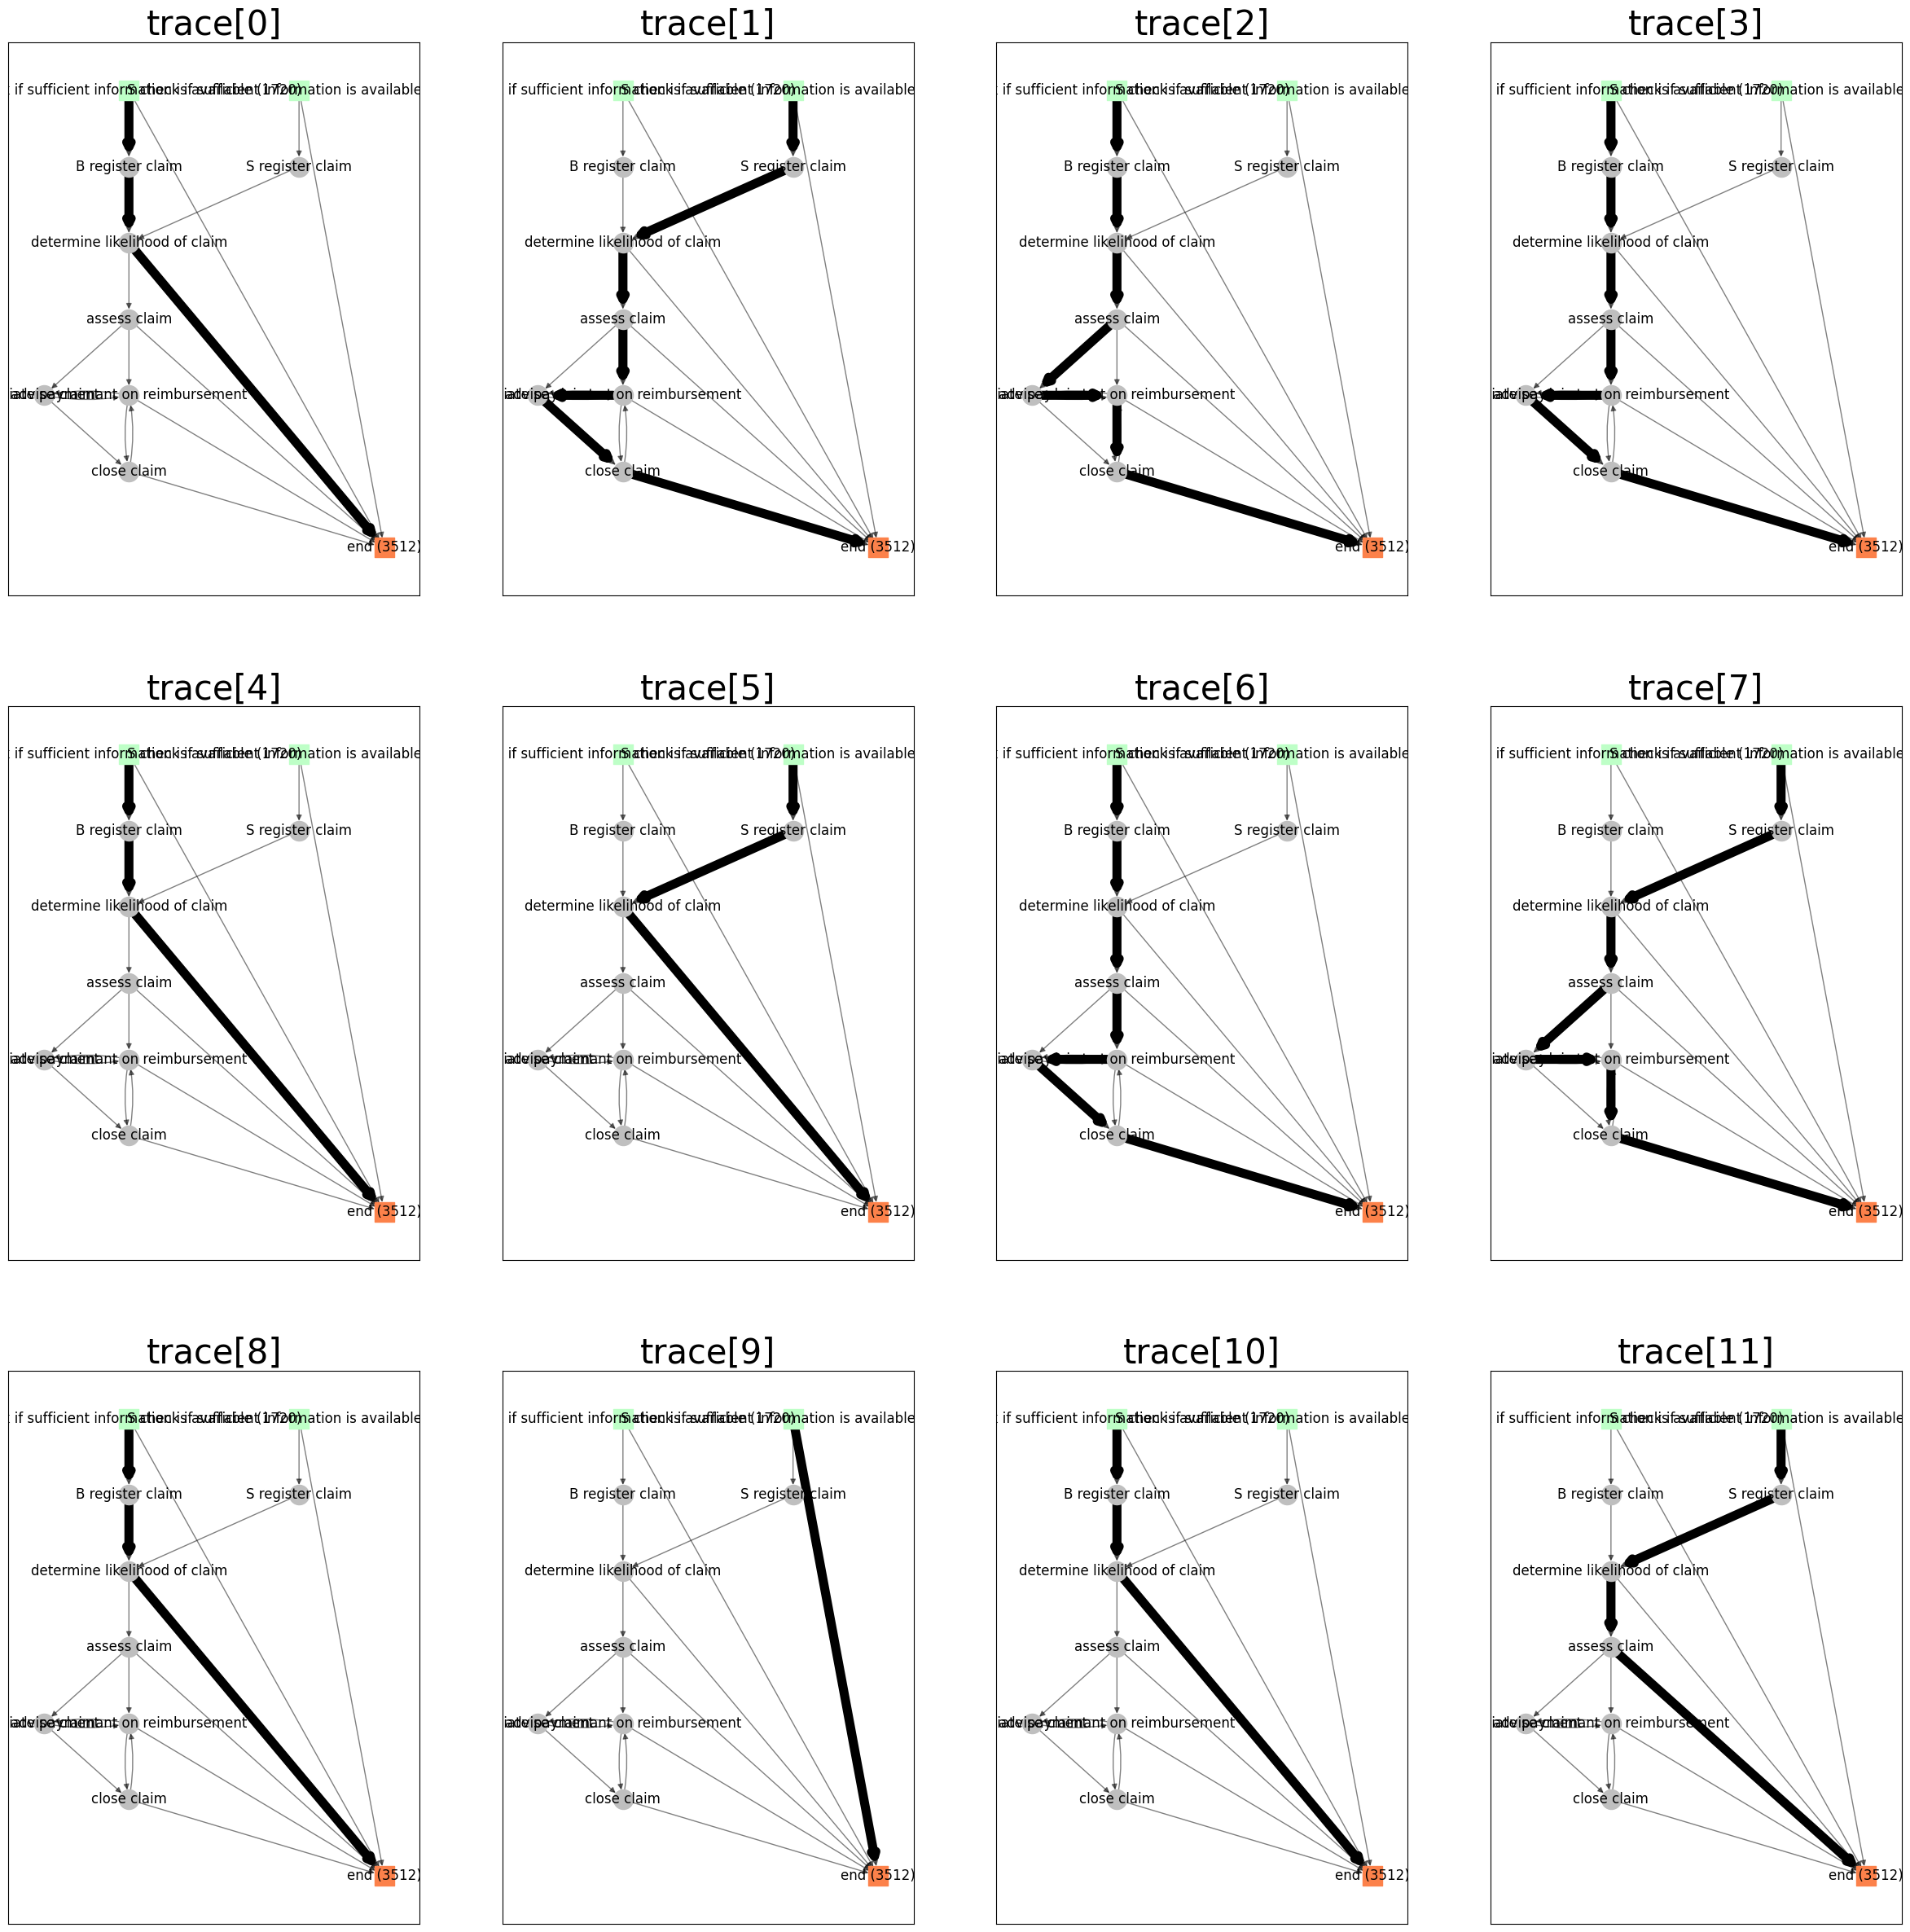

In [7]:
from maxes.analyze_sequence import analyze_xes_trace_sequence

fig, axs = plt.subplots(3, 4)
fig.set_size_inches(30, 30)

for index, ax in enumerate(axs.reshape(-1)):
    trace_graph = analyze_xes_trace_sequence(log__simple_filtered.traces[index].df)
    nx.relabel_nodes(trace_graph, relabel_mapping, copy=False)

    maxes.analyze_sequence.draw_nx_graph(graph, ax=ax, pos=pos)

    nx.draw_networkx_edges(trace_graph, ax=ax, pos=pos, width=8)

    ax.set_title(f"trace[{index}]", fontsize=30)

Sujungus siuos atskirus grafus, i viena, gauname toki vaizda:

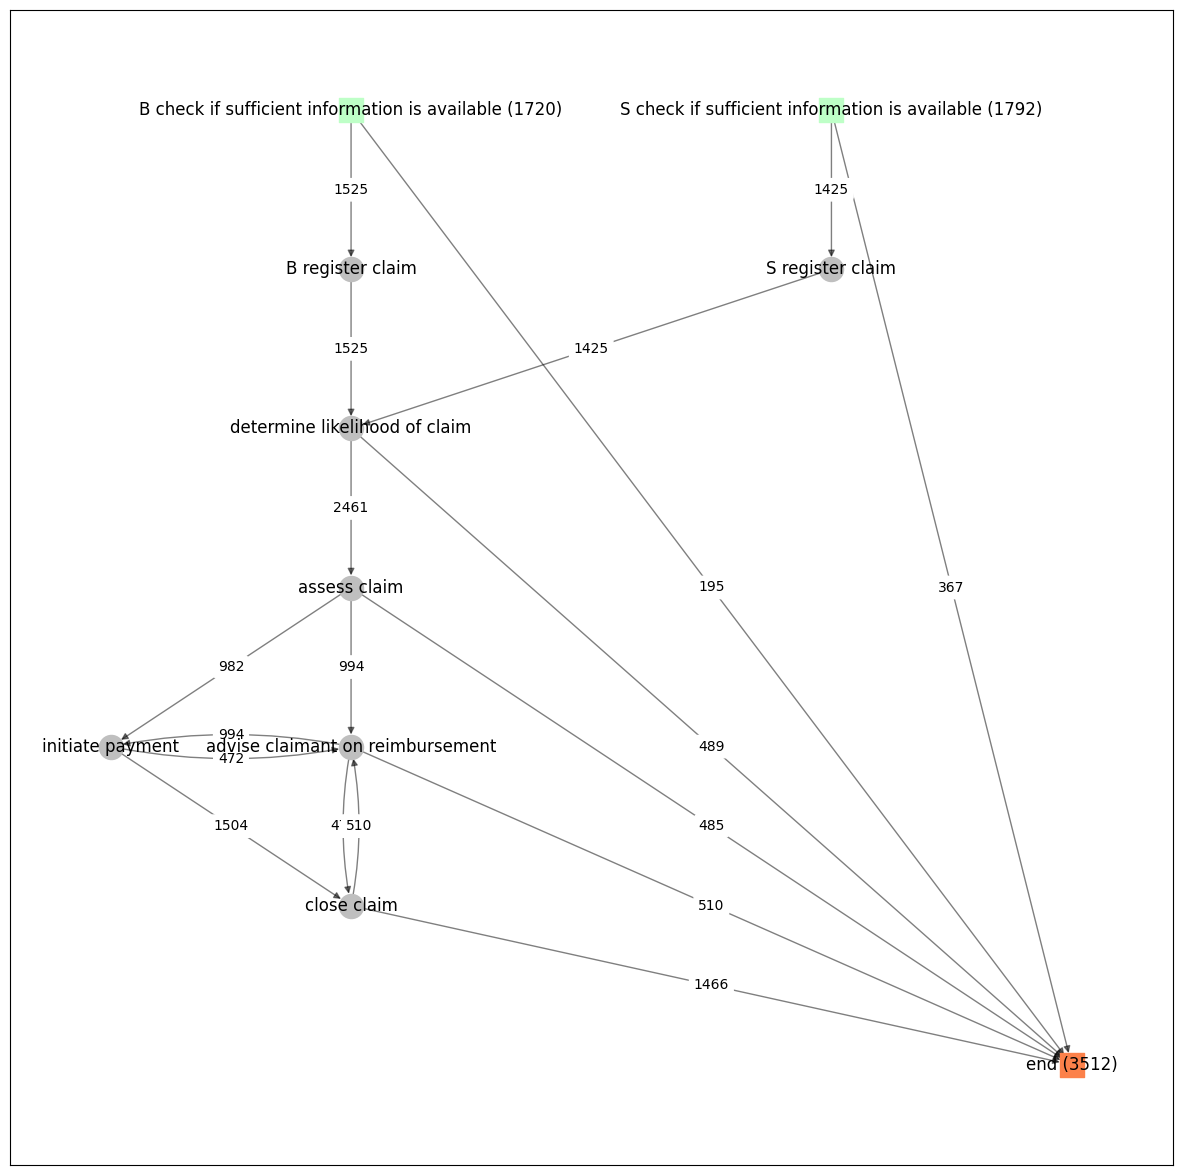

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
maxes.analyze_sequence.draw_nx_graph(graph, edge_label="frequency", ax=ax, pos=pos)

Kai sujungeme trace'u grafus, taip pat suskaiciavome kiekvienos poros ivykiu perejimus skaicius.

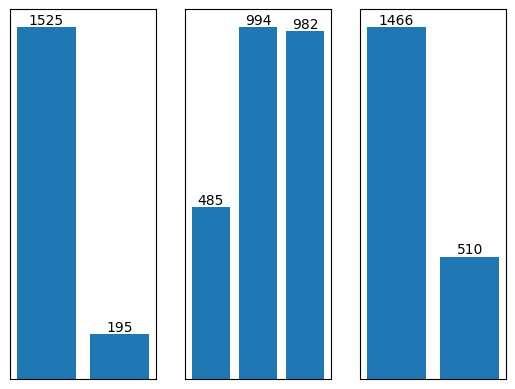

In [10]:
nodes = [
    'B check if sufficient information is available',
    'assess claim',
    'close claim'
]

fig, axs = plt.subplots(1, 3)
# fig.set_size_inches(30, 30)

for index, ax in enumerate(axs.reshape(-1)):
    node = nodes[index]
    data = [(node, data["frequency"]) for node, data in graph[node].items()]
    x = [i[0] for i in data]
    y = [i[1] for i in data]

    ax.bar(x, y, label=None)
    ax.set_xticks([])
    ax.set_yticks([])

    for bar in ax.containers:
        ax.bar_label(bar)

Text(0.5, 1.0, 'From "assess claim" to:')

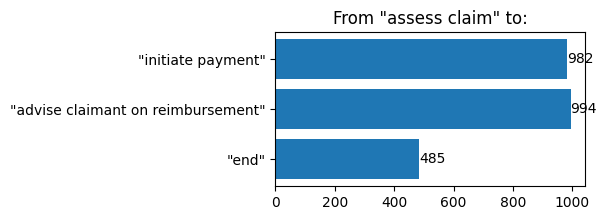

In [23]:
node = 'assess claim'
data = [(node, data["frequency"]) for node, data in graph[node].items()]
x = ["\"" + i[0] + "\"" for i in data]
y = [i[1] for i in data]

fig, ax = plt.subplots()
fig.set_size_inches(4, 2)
ax.barh(x, y, label=None)

for bar in ax.containers:
    ax.bar_label(bar)

ax.set_title(f"From \"{node}\" to:")

Pabandykime sugeneruoti perejimus pagal tas pacias tikimybes:

In [39]:
%autoreload
from maxes.graphs import random_weighted_traverse

def display_sample_sequence():
    sequence = random_weighted_traverse(
        graph,
        min_steps=4,
        max_steps=10,
        weight_feature_name="frequency"
    )
    display(pd.DataFrame({ "concept:name": sequence }))

display_sample_sequence()
display_sample_sequence()
display_sample_sequence()
display_sample_sequence()

,concept:name
0,S check if sufficient information is available
1,S register claim
2,determine likelihood of claim
3,assess claim
4,end


,concept:name
0,B check if sufficient information is available
1,B register claim
2,determine likelihood of claim
3,assess claim
4,advise claimant on reimbursement
5,close claim
6,end


,concept:name
0,S check if sufficient information is available
1,S register claim
2,determine likelihood of claim
3,assess claim
4,initiate payment
5,close claim
6,end


,concept:name
0,B check if sufficient information is available
1,B register claim
2,determine likelihood of claim
3,assess claim
4,initiate payment
5,advise claimant on reimbursement
6,initiate payment
7,advise claimant on reimbursement
8,end


Pagal panasia logika galima kartu generuoti ir "lifecycle:transition" atributa. Grafas tampa sudetingesnis:

In [42]:
%autoreload
from maxes.generators.xes_generator.xes_generator1 import XesGenerator1

generator = XesGenerator1()
generator.fit(log)

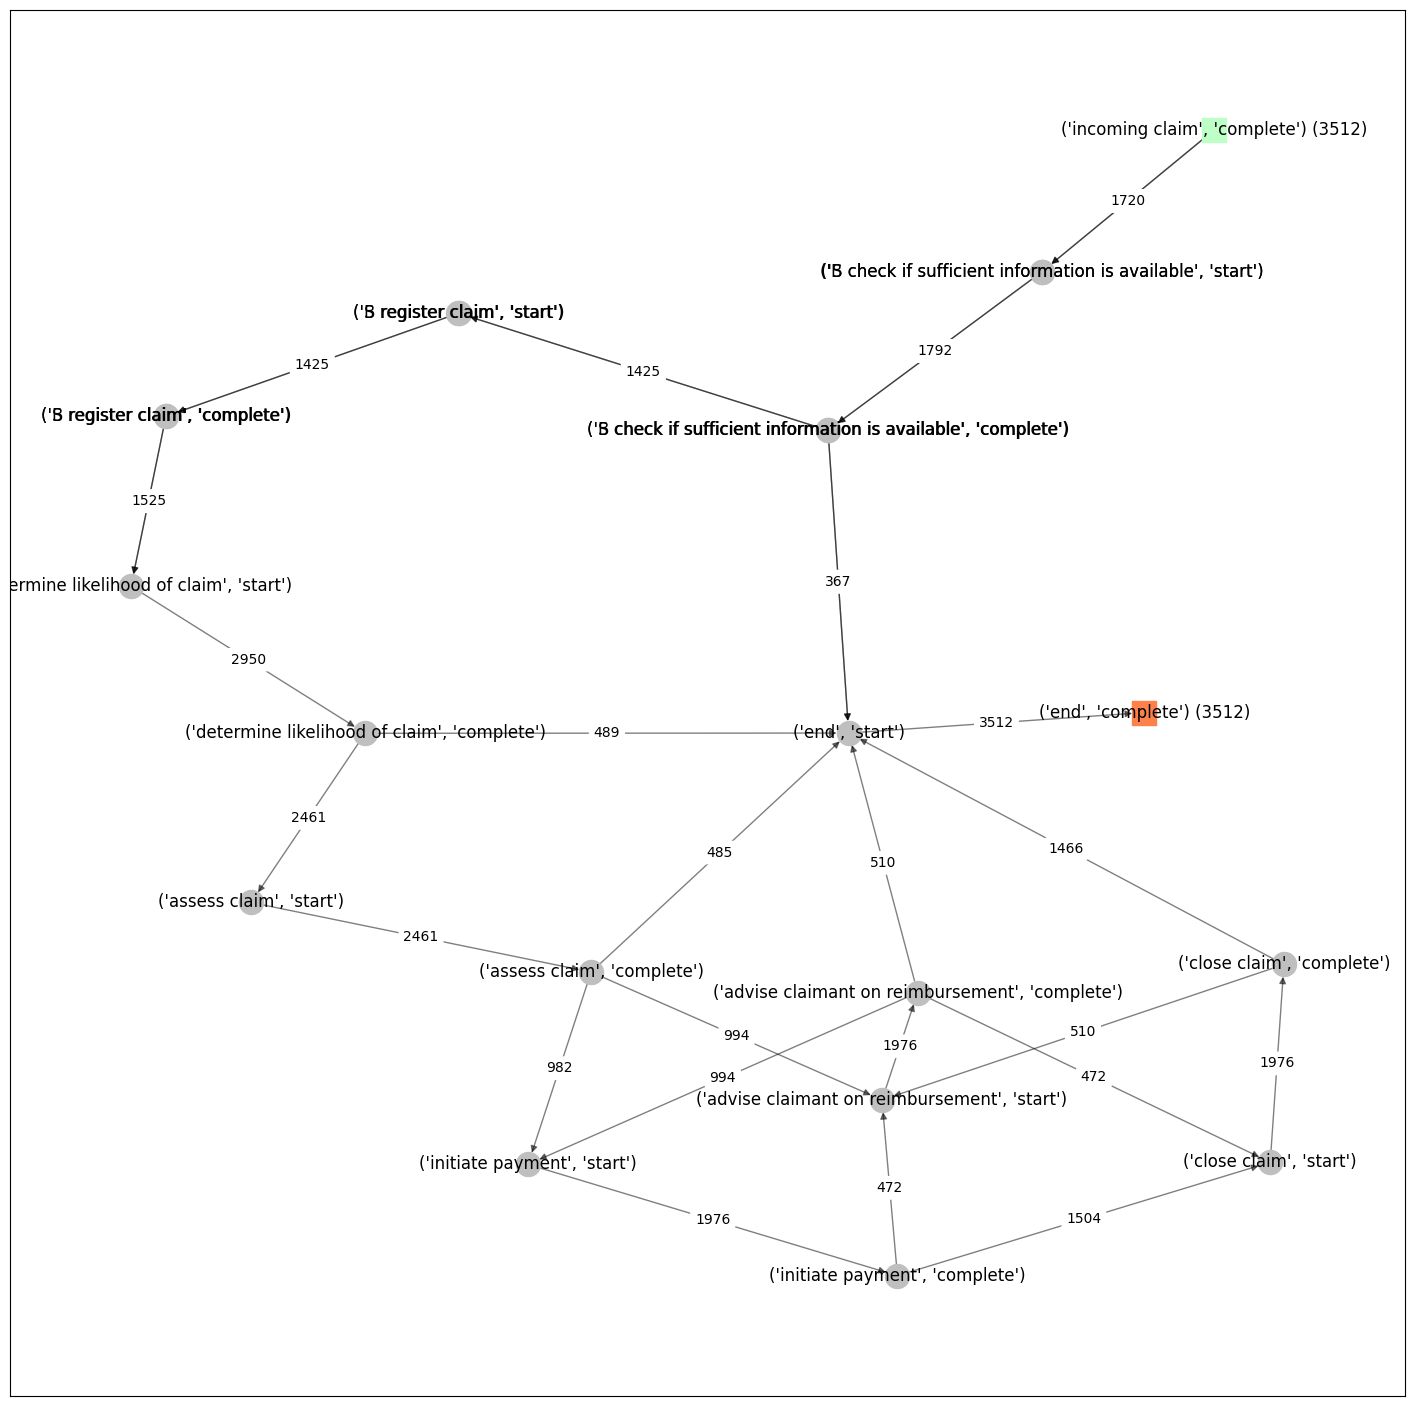

In [43]:
graph = generator.sequence_graph_

fig, ax = plt.subplots()
fig.set_size_inches(18, 18)
maxes.analyze_sequence.draw_nx_graph(graph, edge_label="frequency", ax=ax, pos=nx.kamada_kawai_layout(graph))

In [47]:
def display_sample_sequence():
    sequence = random_weighted_traverse(
        graph,
        min_steps=4,
        max_steps=10,
        weight_feature_name="frequency"
    )
    display(pd.DataFrame(sequence, columns=["concept:name", "lifecycle:transition"]))

display_sample_sequence()
display_sample_sequence()
display_sample_sequence()
display_sample_sequence()

,concept:name,lifecycle:transition
0,incoming claim,complete
1,B check if sufficient information is available,start
2,B check if sufficient information is available,complete
3,B register claim,start
4,B register claim,complete
5,determine likelihood of claim,start
6,determine likelihood of claim,complete
7,end,start
8,end,complete


,concept:name,lifecycle:transition
0,incoming claim,complete
1,S check if sufficient information is available,start
2,S check if sufficient information is available,complete
3,S register claim,start
4,S register claim,complete
5,determine likelihood of claim,start
6,determine likelihood of claim,complete
7,end,start
8,end,complete


,concept:name,lifecycle:transition
0,incoming claim,complete
1,S check if sufficient information is available,start
2,S check if sufficient information is available,complete
3,S register claim,start
4,S register claim,complete
5,determine likelihood of claim,start
6,determine likelihood of claim,complete
7,end,start
8,end,complete


,concept:name,lifecycle:transition
0,incoming claim,complete
1,B check if sufficient information is available,start
2,B check if sufficient information is available,complete
3,B register claim,start
4,B register claim,complete
5,determine likelihood of claim,start
6,determine likelihood of claim,complete
7,end,start
8,end,complete


In [100]:
from maxes.xes_loader2 import XesEvent, XesTrace

generated_trace = XesTrace()
generated_events_sequence = random_weighted_traverse(
    graph,
    min_steps=4,
    max_steps=10,
    weight_feature_name="frequency"
)

for event_sequence_item in generated_events_sequence:
    event = XesEvent()
    generated_trace.events.append(event)

    # concept:name and lifecycle:transition
    concept_name, lifecycle_transition = event_sequence_item
    event.attributes["concept:name"] = concept_name
    event.attributes["lifecycle:transition"] = lifecycle_transition

generated_trace.df
generated_trace.clear_cache()
generated_trace.df

,concept:name,lifecycle:transition
0,incoming claim,complete
1,B check if sufficient information is available,start
2,B check if sufficient information is available,complete
3,B register claim,start
4,B register claim,complete
5,determine likelihood of claim,start
6,determine likelihood of claim,complete
7,end,start
8,end,complete


# 2. "time:timestamp" atributo generavimas

daroma per du zingsnius:

  1. pirmo ivykio laikas (kada atsitiko)

  2. kitu ivykiu trukmes

Pirmas atvejis

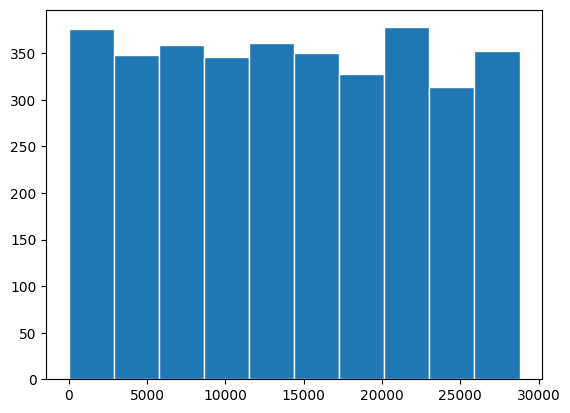

In [53]:
trace_beginning_timestamps_ = [trace.events[0].time_timestamp for trace in log.traces]
data = [date.timestamp() for date in trace_beginning_timestamps_]

plt.hist(data, edgecolor='white')

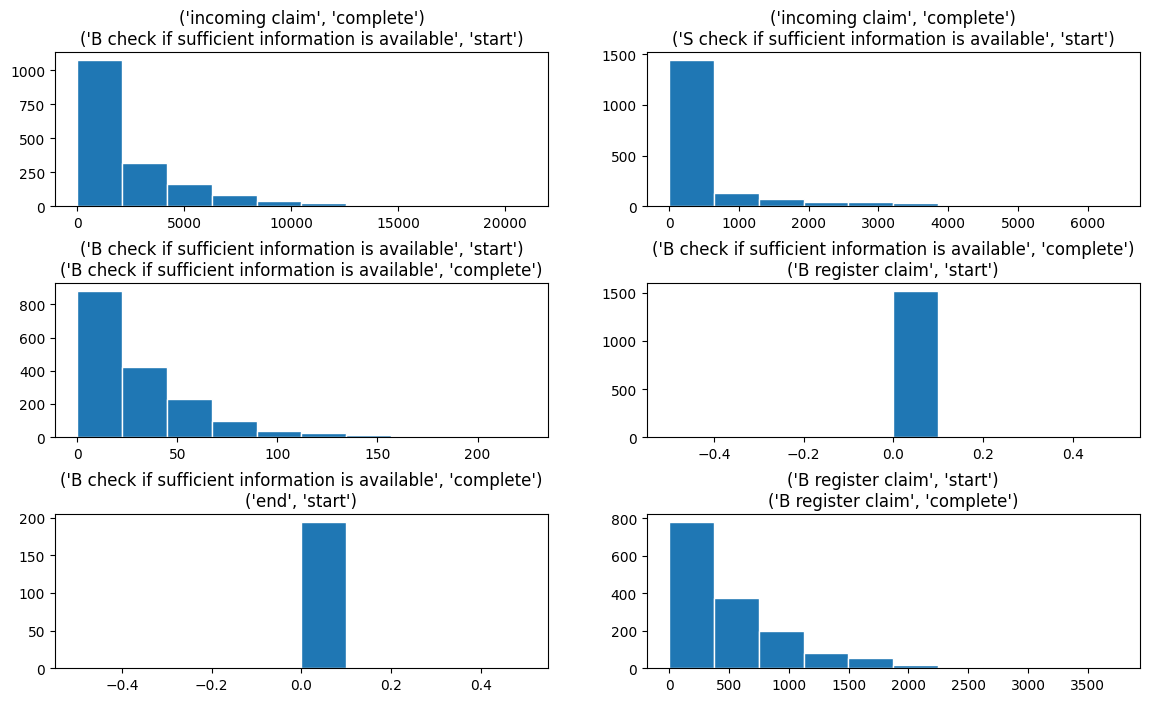

In [82]:
edges = list(generator.sequence_graph_.edges())

fig, axs = plt.subplots(3, 2)
fig.set_size_inches(14, 8)
fig.subplots_adjust(hspace=0.5)

for index, ax in enumerate(axs.reshape(-1)):
    edge = edges[index]
    transition_durations = generator.sequence_graph_.edges[edge]["transition_durations"]
    seconds = [duration.seconds for duration in transition_durations]

    # seconds_series = pd.Series(seconds)
    # seconds_series.describe()

    ax.hist(seconds, edgecolor='white')

    first, second = edge
    ax.set_title(f"{first}\n{second}")

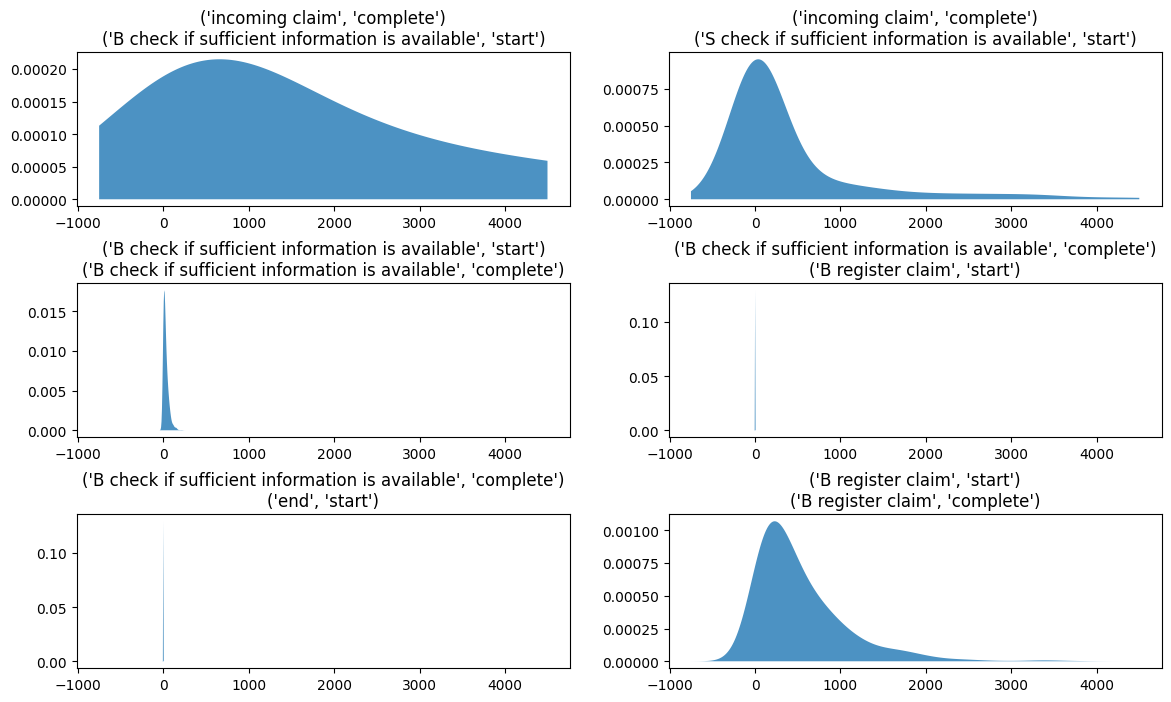

In [93]:
def draw_kde_for_transition(transition_name: str, ax, alpha=0.8):
    model = generator.sequence_graph_.edges[transition_name]["duration_generator"]

    start, end = min(seconds), max(seconds)
    interval_length = end - start
    interval_expansion = interval_length * 0.2
    x = np.linspace(start - interval_expansion, end + interval_expansion, 1000)

    y = np.exp(model.kde_.score_samples(x[:, None]))

    ax.fill_between(x, y, alpha=alpha);

fig, axs = plt.subplots(3, 2)
fig.set_size_inches(14, 8)
fig.subplots_adjust(hspace=0.5)

for index, ax in enumerate(axs.reshape(-1)):
    edge = edges[index]
    draw_kde_for_transition(edge, ax=ax, alpha=0.8)
    first, second = edge
    ax.set_title(f"{first}\n{second}")

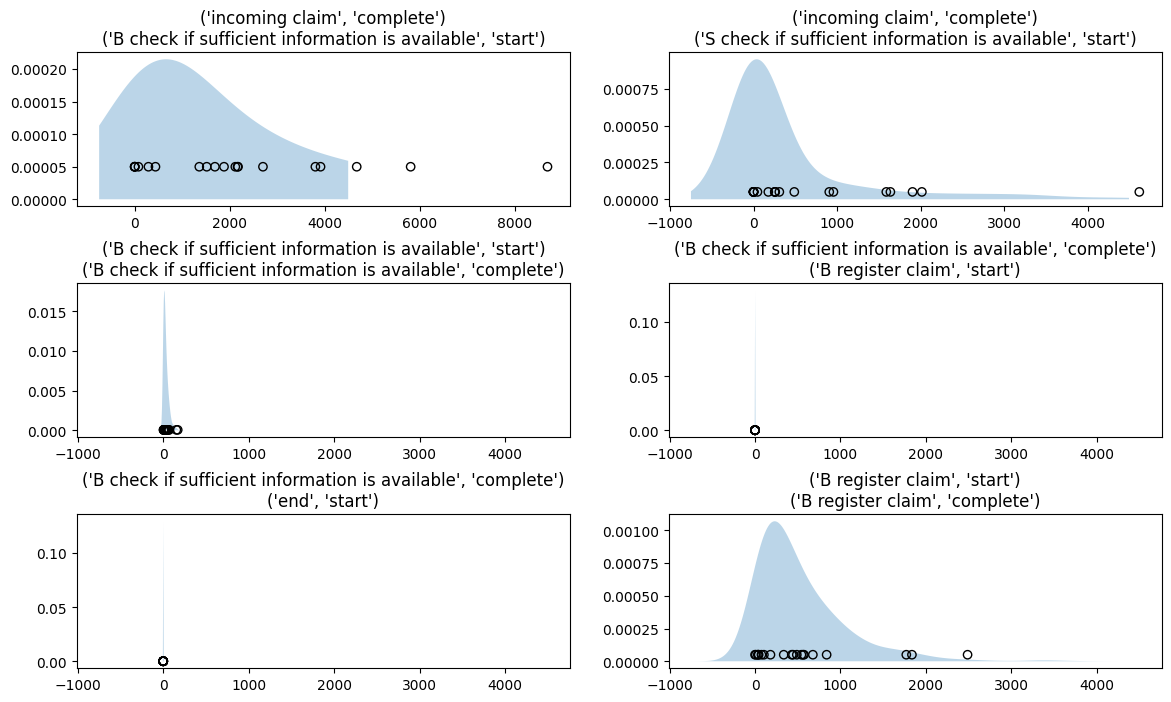

In [94]:
def draw_kde_transition_samples(transition_name: str, ax):
    model = generator.sequence_graph_.edges[transition_name]["duration_generator"]

    samples_x = [sample.seconds for sample in model.sample(n_samples=20)]
    samples_y = [0.00005 for sample in samples_x]

    ax.scatter(samples_x, samples_y, facecolors='none', edgecolors='black')

fig, axs = plt.subplots(3, 2)
fig.set_size_inches(14, 8)
fig.subplots_adjust(hspace=0.5)

for index, ax in enumerate(axs.reshape(-1)):
    edge = edges[index]
    draw_kde_for_transition(edge, ax=ax, alpha=0.3)
    draw_kde_transition_samples(edge, ax=ax)
    first, second = edge
    ax.set_title(f"{first}\n{second}")

In [103]:
import itertools

generated_trace.events[0].attributes["time:timestamp"] = generator.trace_beginning_timestamp_generator_.sample()[0]

for current_event, next_event in itertools.pairwise(generated_trace.events):
    edge = (
        XesGenerator1._get_sequence_graph_node_key(current_event),
        XesGenerator1._get_sequence_graph_node_key(next_event),
    )
    duration_generator = generator.sequence_graph_.edges[edge]["duration_generator"]
    sample_duration = duration_generator.sample()[0]
    next_event.attributes["time:timestamp"] = current_event.time_timestamp + sample_duration

generated_trace.clear_cache()
generated_trace.df

,concept:name,lifecycle:transition,time:timestamp
0,incoming claim,complete,1970-01-01 05:26:31.337887+00:00
1,B check if sufficient information is available,start,1970-01-01 05:27:40.813757+00:00
2,B check if sufficient information is available,complete,1970-01-01 05:28:37.655101+00:00
3,B register claim,start,1970-01-01 05:28:37.655101+00:00
4,B register claim,complete,1970-01-01 05:46:55.315561+00:00
5,determine likelihood of claim,start,1970-01-01 06:48:31.454108+00:00
6,determine likelihood of claim,complete,1970-01-01 06:48:53.375571+00:00
7,end,start,1970-01-01 06:48:53.375571+00:00
8,end,complete,1970-01-01 06:48:54.328176+00:00


# 3. kitu atributu generavimas

atkreipkime demesi i kitu atributu priklausomybe nuo pagrindiniu:

In [110]:
log.traces[0].df[["concept:name", "org:resource"]]

,concept:name,org:resource
0,incoming claim,customer
1,B check if sufficient information is available,Call Centre Agent Brisbane
2,B check if sufficient information is available,Call Centre Agent Brisbane
3,B register claim,Call Centre Agent Brisbane
4,B register claim,Call Centre Agent Brisbane
5,determine likelihood of claim,Claims handler
6,determine likelihood of claim,Claims handler
7,end,Claims handler
8,end,Claims handler


In [129]:
from sklearn.preprocessing import OneHotEncoder

input_encoder = OneHotEncoder()
X_series = log.df["concept:name"]
X_np = np.array(X_series).reshape(-1, 1)
X = input_encoder.fit_transform(X_np)

X.toarray()[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [130]:
output_encoder = OneHotEncoder()
y_series = log.df["org:resource"]
y_np = np.array(y_series).reshape(-1, 1)
y = output_encoder.fit_transform(y_np)

y.toarray()[:5]

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [131]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()
model.fit(X, y)

MLPClassifier()

In [139]:
generated_concept_name = np.array(generated_trace.df["concept:name"]).reshape(-1, 1)
X = input_encoder.transform(generated_concept_name)
y_pred = model.predict(X)
generated_org_resource = output_encoder.inverse_transform(y_pred).ravel()

generated_trace.df["org:resource"] = generated_org_resource

generated_trace.df

,concept:name,lifecycle:transition,time:timestamp,org:resource
0,incoming claim,complete,1970-01-01 05:26:31.337887+00:00,customer
1,B check if sufficient information is available,start,1970-01-01 05:27:40.813757+00:00,Call Centre Agent Brisbane
2,B check if sufficient information is available,complete,1970-01-01 05:28:37.655101+00:00,Call Centre Agent Brisbane
3,B register claim,start,1970-01-01 05:28:37.655101+00:00,Call Centre Agent Brisbane
4,B register claim,complete,1970-01-01 05:46:55.315561+00:00,Call Centre Agent Brisbane
5,determine likelihood of claim,start,1970-01-01 06:48:31.454108+00:00,Claims handler
6,determine likelihood of claim,complete,1970-01-01 06:48:53.375571+00:00,Claims handler
7,end,start,1970-01-01 06:48:53.375571+00:00,Claims handler
8,end,complete,1970-01-01 06:48:54.328176+00:00,Claims handler


# 4. (bonus) everything together

In [144]:
%autoreload
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from maxes.generators.xes_generator.xes_generator3 import XesGenerator3, XesAttributeModelPredictor

model_prototype = Pipeline(steps=[
    ("column selector", ColumnTransformer([
        ("concept_name", OneHotEncoder(), ["concept:name"]),
        ("lifecycle_transition", OneHotEncoder(), ["lifecycle:transition"])
    ])),
    ("classifier", MLPClassifier())
])

final_generator = XesGenerator3(
    attributes_models=[
        XesAttributeModelPredictor(
            attribute="org:resource",
            dependent_attributes=["concept:name", "lifecycle:transition"],
            model=clone(model_prototype),
            output_transformer=OneHotEncoder()
        ),

        XesAttributeModelPredictor(
            attribute="location",
            dependent_attributes=["concept:name", "lifecycle:transition"],
            model=clone(model_prototype),
            output_transformer=OneHotEncoder()
        ),

        XesAttributeModelPredictor(
            attribute="call centre",
            dependent_attributes=["concept:name", "lifecycle:transition"],
            model=clone(model_prototype),
            output_transformer=OneHotEncoder()
        ),

        XesAttributeModelPredictor(
            attribute="outcome",
            dependent_attributes=["concept:name", "lifecycle:transition"],
            model=clone(model_prototype),
            output_transformer=OneHotEncoder()
        )
    ],
    traces_count=1
)
final_generator.fit(log)

In [145]:
final_generated_log = final_generator.generate()

In [147]:
final_generated_log._update_df()
final_generated_log.df

,concept:name,lifecycle:transition,time:timestamp,org:resource,call centre,location,outcome
0,incoming claim,complete,1970-01-01 06:09:22.023586+00:00,customer,Sydney,NaN,NaN
1,S check if sufficient information is available,start,1970-01-01 06:09:22.674022+00:00,Call Centre Agent Sydney,NaN,Sydney,NaN
2,S check if sufficient information is available,complete,1970-01-01 06:09:52.668151+00:00,Call Centre Agent Sydney,NaN,Sydney,NaN
3,S register claim,start,1970-01-01 06:09:51.974692+00:00,Call Centre Agent Sydney,NaN,NaN,NaN
4,S register claim,complete,1970-01-01 06:12:51.376411+00:00,Call Centre Agent Sydney,NaN,NaN,NaN
5,determine likelihood of claim,start,1970-01-01 08:32:46.552581+00:00,Claims handler,NaN,NaN,NaN
6,determine likelihood of claim,complete,1970-01-01 08:33:16.986242+00:00,Claims handler,NaN,NaN,NaN
7,end,start,1970-01-01 08:33:18.945422+00:00,Claims handler,NaN,NaN,processed
8,end,complete,1970-01-01 08:33:19.236025+00:00,Claims handler,NaN,NaN,processed
